In [1]:
# 適宜自分のApplicationPATHまで変更
APP_PATH = '/root'
# APP_PATH = '.'


# 標準モジュール(install不要)
import os
import math
import random
import pdb          # デバッグ用


# import time
# import copy
# from collections import defaultdict
import torch
# import shutil
# import pandas as pd
from skimage import io, transform # scikit-image
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils # 現時点では使ってない
from torch import nn
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
# import zipfile


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

TRAIN_PATH = APP_PATH + '/data/img'
CHECKPOINT_PATH = APP_PATH + '/data/model'
CHECKPOINT_PATH_UNet = CHECKPOINT_PATH + '/UNet'

# os.chdir(APP_PATH)

In [2]:
# ファイルの実行(ノートブック側でランタイムの再接続 or reloadをする)
# importで実行するときはファイルのパスを通す必要がある
# sys.path.append(APP_PATH + '/bin')

# setupなどのOSに関するコマンド実行はその定義ファイルをコマンドで実行
# 関数などのモジュールはimportで扱えるようにして実行
# !python bin/setup.py

# はじめから256にresizeされている
IMG_HEIGHT = 256
IMG_WIDTH = 256

NUM_EPOCHS = 300
# NUM_EPOCHS = 5

In [3]:
#画像データ拡張の関数
def get_train_transform():
    
   return alb.Compose(
       [
        #リサイズ(元画像ですでにしているが)
        alb.Resize(IMG_HEIGHT, IMG_WIDTH),
        #正規化(こちらの細かい値はalbumentations.augmentations.transforms.Normalizeのデフォルトの値を適用)
        alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #水平フリップ（pはフリップする確率）
        alb.HorizontalFlip(p=0.25),
        #垂直フリップ
        alb.VerticalFlip(p=0.25),
        ToTensorV2(),
        ])

#Datasetクラスの定義
class LoadDataSet(Dataset):
        def __init__(self, path, transform=None):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_train_transform()
        
        def __len__(self):
            return len(self.folders)

        def __getitem__(self, idx):
            image_folder = os.path.join(self.path, self.folders[idx], 'images/')
            mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
            image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
            
            # debug
            # print(f'image_folder: {image_folder}')
            # print(f'mask_folder: {mask_folder}')
            # print(f'image_path: {image_path}')
            # print(f'mask_path: {mask_path}')
            
            #画像データの取得
            # 3次元の処理を2次元に変更するのがいろいろめんどくさいから3次元の型で扱うことにする
            ## exec img
            # img = io.imread(image_path)[:,:,:3].astype('float32')
            img = io.imread(image_path)
            # TODO: 正答率がでたら比較としてfloat32でも試してみる
            # print(f'2d img.shape: {img.shape}') # 白黒なのでチャネル数が省略されて2次元データになっている
            img = self.conv_2D_to_3Darray(img)
            # print(f'3d img.shape: {img.shape}')


            ## exec mask
            # img = transform.resize(img,(256,256))
            ## mask = io.imread(mask_path)
            # maskの量が2つ以上になったらここの関数を実行してすべてを得る
            # mask = self.get_mask(mask_folder, 256, 256).astype('float32')
            mask = self.get_mask(mask_folder, IMG_HEIGHT, IMG_WIDTH) # nint8でOK?
            # print(f'calced mask.shape: {mask.shape}')

            # 前処理をするためにひとつにまとめる
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            return (img,mask)
        
        def conv_2D_to_3Darray(self, arr):
            # print(f'exec conv_2D_to_3Darray')
            image = Image.fromarray(arr)
            image = image.convert("RGB")
            # 変換するならここでfloat32にする
            arr = np.asarray(image, np.uint8)
            # print(f'to3d arr shape: {arr.shape}')
            return arr

        def conv_3D_to_2Darray(self, arr):
            # print(f'exec conv_3D_to_2Darray')
            image = Image.fromarray(arr)
            image = image.convert("L")
            arr = np.asarray(image, np.uint8) # 変換するならここでfloat32にする
            # print(f'to2d arr shape: {arr.shape}')
            # arr = np.transpose(arr, (2, 0, 1))
            # print(f'arr transpose shape: {arr.shape}')
            return arr

        #マスクデータの取得
        def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            # print(f'len(os.listdir(mask_folder)): {len(os.listdir(mask_folder))}')
            for mask_ in os.listdir(mask_folder):
                    mask_ = io.imread(os.path.join(mask_folder,mask_))
                    # RGBからLへ
                    mask_ = self.conv_3D_to_2Darray(mask_)
                    mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
                    mask_ = np.expand_dims(mask_,axis=-1)
                    mask = np.maximum(mask, mask_)

            return mask

# データセットを確認する
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())


# 辞書型のときに要素を取得するマジックメソッド　以下と同じ意味
# image, mask = train_dataset.__getitem__(0)
image, mask = train_dataset[0]
print(image.shape)
print(mask.shape)

#Print total number of unique images.
# フォルダーの長さを表示　以下と同じ意味
train_dataset.__len__()
print(len(train_dataset))


torch.Size([3, 256, 256])
torch.Size([256, 256, 1])
60


[13, 1, 54]


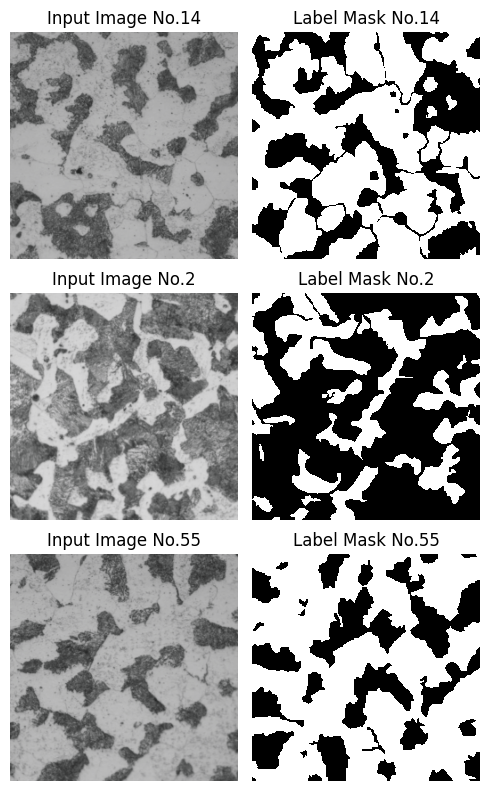

In [4]:
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    #下は画像拡張での正規化を元に戻しています
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

def visualize_dataset(n_images, num_range, predict=None):
    #TODO:表示時に水平・垂直クリップがかるからかからないようにする(Predictedのほうも)
    images = random.sample(range(0, num_range), n_images)
    figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
    print(images)
    for i in range(0, len(images)):
        img_no = images[i]
        image, mask = train_dataset[i]
        image = format_image(image)
        mask = format_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

num_range = len(train_dataset)
visualize_dataset(3, num_range)

In [5]:
split_ratio = 0.25
train_size=int(np.round(train_dataset.__len__()*(1 - split_ratio),0))
valid_size=int(np.round(train_dataset.__len__()*split_ratio,0))
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=valid_data, batch_size=10)

print("Length of train　data: {}".format(len(train_data)))
print("Length of validation　data: {}".format(len(valid_data)))

Length of train　data: 45
Length of validation　data: 15


In [6]:
# UNet
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        # 資料中の『FCN』に当たる部分
        self.conv1 = conv_bn_relu(input_channels,64)
        self.conv2 = conv_bn_relu(64, 128)
        self.conv3 = conv_bn_relu(128, 256)
        self.conv4 = conv_bn_relu(256, 512)
        self.conv5 = conv_bn_relu(512, 1024)
        self.down_pooling = nn.MaxPool2d(2)

        # 資料中の『Up Sampling』に当たる部分
        self.up_pool6 = up_pooling(1024, 512)
        self.conv6 = conv_bn_relu(1024, 512)
        self.up_pool7 = up_pooling(512, 256)
        self.conv7 = conv_bn_relu(512, 256)
        self.up_pool8 = up_pooling(256, 128)
        self.conv8 = conv_bn_relu(256, 128)
        self.up_pool9 = up_pooling(128, 64)
        self.conv9 = conv_bn_relu(128, 64)
        self.conv10 = nn.Conv2d(64, output_channels, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        # 正規化
        x = x/255.

        # 資料中の『FCN』に当たる部分
        x1 = self.conv1(x)
        p1 = self.down_pooling(x1)
        x2 = self.conv2(p1)
        p2 = self.down_pooling(x2)
        x3 = self.conv3(p2)
        p3 = self.down_pooling(x3)
        x4 = self.conv4(p3)
        p4 = self.down_pooling(x4)
        x5 = self.conv5(p4)

        # 資料中の『Up Sampling』に当たる部分, torch.catによりSkip Connectionをしている
        p6 = self.up_pool6(x5)
        x6 = torch.cat([p6, x4], dim=1)
        x6 = self.conv6(x6)

        p7 = self.up_pool7(x6)
        x7 = torch.cat([p7, x3], dim=1)
        x7 = self.conv7(x7)

        p8 = self.up_pool8(x7)
        x8 = torch.cat([p8, x2], dim=1)
        x8 = self.conv8(x8)

        p9 = self.up_pool9(x8)
        x9 = torch.cat([p9, x1], dim=1)
        x9 = self.conv9(x9)

        output = self.conv10(x9)
        output = torch.sigmoid(output)

        return output

#畳み込みとバッチ正規化と活性化関数Reluをまとめている
def conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    )

def down_pooling():
    return nn.MaxPool2d(2)

def up_pooling(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        #転置畳み込み
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )



In [7]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        
        return 1 - dice


In [8]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU

In [9]:
#<---------------各インスタンス作成---------------------->
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = DiceLoss()
accuracy_metric = IoU()

valid_loss_min = np.Inf

best_model_file = '/best_model.pth'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(NUM_EPOCHS):
  #<---------------トレーニング---------------------->
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      ## 損失計算
      loss = criterion(output, y_train)
      losses_value = loss.item()
      ## 精度評価
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")
    #<---------------評価---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## 損失計算
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## 精度評価
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}")
    print(f"Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}")

    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    ## 容量をとるので必要になったら保存する
    # checkpoint_file = "/checkpoint_{}_weight.pth".format(epoch+1)
    # checkpointの保存
    # torch.save(checkpoint, CHECKPOINT_PATH_UNet + checkpoint_file)
    
    # 評価データにおいて最高精度のモデルのcheckpointの保存
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        torch.save(checkpoint, CHECKPOINT_PATH_UNet + best_model_file)
        valid_loss_min = total_valid_loss[-1]

    print("")
    


Epoch: 1, loss: 0.09055332813180739, IoU: 0.833931777255


Train Loss: 0.15861022216808726, Train IOU: 0.7432902055681996
Valid Loss: 0.10107414761998695, Valid IOU: 0.8181156493825862
Validation loss decreased (inf --> 0.101074).  Saving model ...



Epoch: 2, loss: 0.09911067090283099, IoU: 0.819653405086


Train Loss: 0.08073487732605303, Train IOU: 0.8511758708906318
Valid Loss: 0.10022523824213325, Valid IOU: 0.8207724324623488
Validation loss decreased (0.101074 --> 0.100225).  Saving model ...



Epoch: 3, loss: 0.05989098391594383, IoU: 0.886986776563


Train Loss: 0.06112059429761156, Train IOU: 0.8852358402525564
Valid Loss: 0.08065932035085338, Valid IOU: 0.8530574204731376
Validation loss decreased (0.100225 --> 0.080659).  Saving model ...



Epoch: 4, loss: 0.1557109209990507, IoU: 0.7305371651987


Train Loss: 0.0862605325352036, Train IOU: 0.8433529357974867
Valid Loss: 0.09656394036080373, Valid IOU: 0.8265489484514399



Epoch: 5, loss: 0.11546056382358694, IoU: 0.792981940273


Train Loss: 0.07202364551643795, Train IOU: 0.8668727407377048
Valid Loss: 0.07773748897827021, Valid IOU: 0.8572895983232864
Validation loss decreased (0.080659 --> 0.077737).  Saving model ...



Epoch: 6, loss: 0.052460326192490414, IoU: 0.90030938593


Train Loss: 0.06244134960254537, Train IOU: 0.8826541129144359
Valid Loss: 0.08218850403045252, Valid IOU: 0.8503065410436106



Epoch: 7, loss: 0.0697558981973142, IoU: 0.8695857215234


Train Loss: 0.06227922975634494, Train IOU: 0.8831133143107186
Valid Loss: 0.08304962171511893, Valid IOU: 0.8487240786998895



Epoch: 8, loss: 0.04285034176219693, IoU: 0.917820867180


Train Loss: 0.05778783136862089, Train IOU: 0.890900610525795
Valid Loss: 0.0779617163357606, Valid IOU: 0.8572030179403944



Epoch: 9, loss: 0.06475788914794878, IoU: 0.878361554787


Train Loss: 0.06580276950437151, Train IOU: 0.8773694408816757
Valid Loss: 0.08036611233481372, Valid IOU: 0.8531600690838463



Epoch: 10, loss: 0.0768471564805141, IoU: 0.857274140166


Train Loss: 0.06255644983097737, Train IOU: 0.8827121912024941
Valid Loss: 0.07513452925594127, Valid IOU: 0.8618745979440996
Validation loss decreased (0.077737 --> 0.075135).  Saving model ...



Epoch: 11, loss: 0.12118598460406738, IoU: 0.78382590033


Train Loss: 0.06341871942189403, Train IOU: 0.8821809655154029
Valid Loss: 0.06514069423066471, Valid IOU: 0.8786473166954285
Validation loss decreased (0.075135 --> 0.065141).  Saving model ...



Epoch: 12, loss: 0.062105348566375396, IoU: 0.8830526736


Train Loss: 0.05677343821960246, Train IOU: 0.8927482978956756
Valid Loss: 0.0673047648659319, Valid IOU: 0.8751665080844651



Epoch: 13, loss: 0.03975638522454039, IoU: 0.92352770999


Train Loss: 0.053828751591162, Train IOU: 0.8981058228043288
Valid Loss: 0.06582255596215958, Valid IOU: 0.8776749130809158



Epoch: 14, loss: 0.3237654841758548, IoU: 0.510843060445


Train Loss: 0.09890820211975507, Train IOU: 0.8367710116308308
Valid Loss: 0.06800777098203742, Valid IOU: 0.8736797348835268



Epoch: 15, loss: 0.11706680891699728, IoU: 0.79040379806


Train Loss: 0.07212504487889101, Train IOU: 0.8672873329019186
Valid Loss: 0.06771011962959617, Valid IOU: 0.8739105066523887



Epoch: 16, loss: 0.04655261059498461, IoU: 0.91103648334


Train Loss: 0.05410468662027908, Train IOU: 0.8974494474040486
Valid Loss: 0.07040010985702894, Valid IOU: 0.8698421320433891



Epoch: 17, loss: 0.062483288337931375, IoU: 0.8823827693


Train Loss: 0.05422186077022453, Train IOU: 0.897218258964449
Valid Loss: 0.06378744310333478, Valid IOU: 0.8809861688685166
Validation loss decreased (0.065141 --> 0.063787).  Saving model ...



Epoch: 18, loss: 0.045285908072475234, IoU: 0.9133522773


Train Loss: 0.05677308138237449, Train IOU: 0.8927922102449065
Valid Loss: 0.07666666441827219, Valid IOU: 0.859460396948079



Epoch: 19, loss: 0.03237117543961432, IoU: 0.93728787887


Train Loss: 0.0529176789767644, Train IOU: 0.8999657956663132
Valid Loss: 0.07708391072273069, Valid IOU: 0.85881428026093



Epoch: 20, loss: 0.07724821772383217, IoU: 0.85658269660


Train Loss: 0.054967319063251384, Train IOU: 0.8960719418394648
Valid Loss: 0.06414885359709421, Valid IOU: 0.8805541726027035



Epoch: 21, loss: 0.05364495415388204, IoU: 0.89817278534


Train Loss: 0.06624980077241652, Train IOU: 0.8761368249403727
Valid Loss: 0.06615645711434293, Valid IOU: 0.8770694505259389



Epoch: 22, loss: 0.1823170599597813, IoU: 0.691594419686


Train Loss: 0.07652438024239969, Train IOU: 0.8623838299144225
Valid Loss: 0.0718802923136298, Valid IOU: 0.8670021241901851



Epoch: 23, loss: 0.05575785085442353, IoU: 0.89437403507


Train Loss: 0.057303021586404455, Train IOU: 0.8917815983368614
Valid Loss: 0.06820276135696324, Valid IOU: 0.8732295226209241



Epoch: 24, loss: 0.059509720550865564, IoU: 0.8876658308


Train Loss: 0.05616967910713113, Train IOU: 0.8940380681394325
Valid Loss: 0.07442322743505048, Valid IOU: 0.8630914851967938



Epoch: 25, loss: 0.03641932715744778, IoU: 0.92972100549


Train Loss: 0.05190510025299311, Train IOU: 0.9014844121451899
Valid Loss: 0.07000124603883828, Valid IOU: 0.8705908985469908



Epoch: 26, loss: 0.03078109954454411, IoU: 0.94027628753


Train Loss: 0.051655002927210036, Train IOU: 0.9020689582491501
Valid Loss: 0.07084957539530601, Valid IOU: 0.8691846464841803



Epoch: 27, loss: 0.05813748083790016, IoU: 0.89011382068


Train Loss: 0.051102336410331, Train IOU: 0.9028226244384564
Valid Loss: 0.06785071684317379, Valid IOU: 0.8741036985169006



Epoch: 28, loss: 0.18638404356646798, IoU: 0.68579561782


Train Loss: 0.07204575998959477, Train IOU: 0.8705550325728801
Valid Loss: 0.06480129950575714, Valid IOU: 0.8793595784399592



Epoch: 29, loss: 0.036456299256649616, IoU: 0.9296521742


Train Loss: 0.05050523883213474, Train IOU: 0.9040711061347206
Valid Loss: 0.061720645044540445, Valid IOU: 0.8846352819276003
Validation loss decreased (0.063787 --> 0.061721).  Saving model ...



Epoch: 30, loss: 0.04185579878324319, IoU: 0.91965158938


Train Loss: 0.05039447502589336, Train IOU: 0.9045303295639033
Valid Loss: 0.06316876639257935, Valid IOU: 0.8822988061888695



Epoch: 31, loss: 0.05989533002593994, IoU: 0.88697904289


Train Loss: 0.05017557483105495, Train IOU: 0.9045243131229732
Valid Loss: 0.06149986288591397, Valid IOU: 0.8851909923388255
Validation loss decreased (0.061721 --> 0.061500).  Saving model ...



Epoch: 32, loss: 0.09042832716115956, IoU: 0.83414211217


Train Loss: 0.05442701370533805, Train IOU: 0.897462712402217
Valid Loss: 0.05920263751807581, Valid IOU: 0.8891406840512209
Validation loss decreased (0.061500 --> 0.059203).  Saving model ...



Epoch: 33, loss: 0.044928438989190744, IoU: 0.9140069025


Train Loss: 0.04811098918341117, Train IOU: 0.9082403220908988
Valid Loss: 0.058379634906235045, Valid IOU: 0.890587267950579
Validation loss decreased (0.059203 --> 0.058380).  Saving model ...



Epoch: 34, loss: 0.042480570592242084, IoU: 0.9185012261


Train Loss: 0.04845995120800952, Train IOU: 0.9078008332056703
Valid Loss: 0.05710740173853812, Valid IOU: 0.8928149840541137
Validation loss decreased (0.058380 --> 0.057107).  Saving model ...



Epoch: 35, loss: 0.07224836080050201, IoU: 0.86523984262


Train Loss: 0.05113806188209029, Train IOU: 0.9031022944154031
Valid Loss: 0.05774774383299558, Valid IOU: 0.8917760804438277



Epoch: 36, loss: 0.043676752965546406, IoU: 0.9163022823


Train Loss: 0.04737821957869361, Train IOU: 0.9096487558803945
Valid Loss: 0.05713594972133135, Valid IOU: 0.8928249897351227



Epoch: 37, loss: 0.08188048810445758, IoU: 0.84863340808


Train Loss: 0.05559315154847642, Train IOU: 0.8953370982920996
Valid Loss: 0.0622340822396959, Valid IOU: 0.8836413572946642



Epoch: 38, loss: 0.05381041858457014, IoU: 0.89787474985


Train Loss: 0.05142295516220703, Train IOU: 0.902297949611665
Valid Loss: 0.08364690082287018, Valid IOU: 0.8481278666691682



Epoch: 39, loss: 0.04429741406292831, IoU: 0.91516337165


Train Loss: 0.05999148772708551, Train IOU: 0.8886727154254365
Valid Loss: 0.06150881078621445, Valid IOU: 0.8851308193905567



Epoch: 40, loss: 0.046276167878035235, IoU: 0.9115414165


Train Loss: 0.051456918749519055, Train IOU: 0.9021844883427633
Valid Loss: 0.06560439149198188, Valid IOU: 0.8780607312533775



Epoch: 41, loss: 0.07944184075818139, IoU: 0.85280977063


Train Loss: 0.06198662927028566, Train IOU: 0.8839476485668296
Valid Loss: 0.07644154628631594, Valid IOU: 0.8580406748811913



Epoch: 42, loss: 0.06872208375624334, IoU: 0.87139418509


Train Loss: 0.06063649230271491, Train IOU: 0.8857648086345027
Valid Loss: 0.06888028860199708, Valid IOU: 0.872442739327934



Epoch: 43, loss: 0.09128946663687598, IoU: 0.83269477079


Train Loss: 0.05912692536214057, Train IOU: 0.8888534173317646
Valid Loss: 0.06759155055990917, Valid IOU: 0.8747171460830836



Epoch: 44, loss: 0.04994740547055021, IoU: 0.90485755737


Train Loss: 0.054198896039690546, Train IOU: 0.8979222725983096
Valid Loss: 0.06084316008248436, Valid IOU: 0.8859054005515559



Epoch: 45, loss: 0.04474006001244257, IoU: 0.91435201534


Train Loss: 0.053104805852820645, Train IOU: 0.8993140386278299
Valid Loss: 0.06519735734949583, Valid IOU: 0.8788319585084248



Epoch: 46, loss: 0.06181962831980714, IoU: 0.88355931313


Train Loss: 0.05240351771513936, Train IOU: 0.900993540126645
Valid Loss: 0.06170505571299367, Valid IOU: 0.8848521113623165



Epoch: 47, loss: 0.06930178223728989, IoU: 0.87037969876


Train Loss: 0.05127957236429832, Train IOU: 0.90261405002295
Valid Loss: 0.058189146073081066, Valid IOU: 0.8908996822957314



Epoch: 48, loss: 0.03568544607807156, IoU: 0.93108841068


Train Loss: 0.04771631370300713, Train IOU: 0.9090233226695787
Valid Loss: 0.058045875562445504, Valid IOU: 0.8911318694274559



Epoch: 49, loss: 0.036902119605540795, IoU: 0.9288225275


Train Loss: 0.048710264375510404, Train IOU: 0.9075165126027593
Valid Loss: 0.0616036201237824, Valid IOU: 0.8849913387684627



Epoch: 50, loss: 0.10120351577112263, IoU: 0.81619515066


Train Loss: 0.05511367521355555, Train IOU: 0.896452082229467
Valid Loss: 0.05997990697738792, Valid IOU: 0.8878202562996935



Epoch: 51, loss: 0.05446912604574583, IoU: 0.89668926499


Train Loss: 0.05183201748622494, Train IOU: 0.9014947262661055
Valid Loss: 0.05937737948367672, Valid IOU: 0.8888906602150326



Epoch: 52, loss: 0.10103812720571592, IoU: 0.81646795322


Train Loss: 0.05617279600521474, Train IOU: 0.8945384668915031
Valid Loss: 0.06370100773585646, Valid IOU: 0.8810587709058837



Epoch: 53, loss: 0.07197555444517267, IoU: 0.86571457465


Train Loss: 0.05257860904834029, Train IOU: 0.9002838099222389
Valid Loss: 0.06172995554500438, Valid IOU: 0.8845685320542866



Epoch: 54, loss: 0.04217108854159812, IoU: 0.91907087254


Train Loss: 0.05187028622967895, Train IOU: 0.9014378391530506
Valid Loss: 0.0690504528596389, Valid IOU: 0.8723317868775855



Epoch: 55, loss: 0.07158691684856056, IoU: 0.86639123579


Train Loss: 0.053976278407812564, Train IOU: 0.8979011050177583
Valid Loss: 0.06273088174538011, Valid IOU: 0.8829130885683338



Epoch: 56, loss: 0.04420675831123089, IoU: 0.91532969660


Train Loss: 0.04758564511172705, Train IOU: 0.9091800508617496
Valid Loss: 0.059586860044348156, Valid IOU: 0.8884188333431966



Epoch: 57, loss: 0.04632105414609056, IoU: 0.91145939069


Train Loss: 0.046683105512668986, Train IOU: 0.9108863980859574
Valid Loss: 0.05972555414555991, Valid IOU: 0.8882734413549713



Epoch: 58, loss: 0.051645065132479906, IoU: 0.9017825871


Train Loss: 0.05137863809544174, Train IOU: 0.9028379429024916
Valid Loss: 0.05729785556078576, Valid IOU: 0.8925207848870184



Epoch: 59, loss: 0.06948638427423015, IoU: 0.87005688354


Train Loss: 0.05110656722819151, Train IOU: 0.9030510402355374
Valid Loss: 0.06184057379793456, Valid IOU: 0.8846874289160613



Epoch: 60, loss: 0.07562516184229573, IoU: 0.85938404616


Train Loss: 0.055545133437036306, Train IOU: 0.895052074754835
Valid Loss: 0.066773495795094, Valid IOU: 0.876319896596397



Epoch: 61, loss: 0.03948702465980458, IoU: 0.92402608817


Train Loss: 0.048853164864662936, Train IOU: 0.9070754490018231
Valid Loss: 0.0722498138202185, Valid IOU: 0.8665841110015631



Epoch: 62, loss: 0.03050451399492282, IoU: 0.94079702847


Train Loss: 0.04939576675605493, Train IOU: 0.9062254711330959
Valid Loss: 0.06618247511533237, Valid IOU: 0.8768625380992285



Epoch: 63, loss: 0.11089567713734094, IoU: 0.80034960807


Train Loss: 0.05747673436739378, Train IOU: 0.8925213002891583
Valid Loss: 0.06251051209421732, Valid IOU: 0.8832386243437633



Epoch: 64, loss: 0.04918810817304542, IoU: 0.90623614346


Train Loss: 0.05018510807734766, Train IOU: 0.9044981593672278
Valid Loss: 0.06300384884379162, Valid IOU: 0.8823551868951116



Epoch: 65, loss: 0.04363208159143206, IoU: 0.91638435725


Train Loss: 0.05001742315653572, Train IOU: 0.9050707710845662
Valid Loss: 0.05988948445288789, Valid IOU: 0.8877873273615866



Epoch: 66, loss: 0.1415728453160201, IoU: 0.751969527194


Train Loss: 0.0641826430501935, Train IOU: 0.8818499281435299
Valid Loss: 0.060126318242058885, Valid IOU: 0.8872499477897322



Epoch: 67, loss: 0.05363491525057107, IoU: 0.89819097318


Train Loss: 0.04869473800430861, Train IOU: 0.9072758132017229
Valid Loss: 0.0594715123523723, Valid IOU: 0.8886510938792609



Epoch: 68, loss: 0.05138620048791198, IoU: 0.90225079501


Train Loss: 0.048203241365332564, Train IOU: 0.9080352269318096
Valid Loss: 0.05724512588811109, Valid IOU: 0.8925752737346082



Epoch: 69, loss: 0.04084387341523743, IoU: 0.92151797930


Train Loss: 0.04623242789379591, Train IOU: 0.9116913324443351
Valid Loss: 0.05514384551504964, Valid IOU: 0.8962387264424868
Validation loss decreased (0.057107 --> 0.055144).  Saving model ...



Epoch: 70, loss: 0.05156828992493201, IoU: 0.90192142736


Train Loss: 0.049368884474145336, Train IOU: 0.9062134731622958
Valid Loss: 0.05661556227158032, Valid IOU: 0.8935430366759973



Epoch: 71, loss: 0.059836894475294056, IoU: 0.8870830752


Train Loss: 0.04710808388902286, Train IOU: 0.9101467500057373
Valid Loss: 0.05500242991339227, Valid IOU: 0.8964534469525938
Validation loss decreased (0.055144 --> 0.055002).  Saving model ...



Epoch: 72, loss: 0.053534070777633835, IoU: 0.8983726086


Train Loss: 0.05005774684628126, Train IOU: 0.9049565224195923
Valid Loss: 0.05509012194228946, Valid IOU: 0.8961585045540373



Epoch: 73, loss: 0.03490942935531738, IoU: 0.93253638275


Train Loss: 0.04639800831644318, Train IOU: 0.9117298087956902
Valid Loss: 0.056219904952064303, Valid IOU: 0.8941345024492585



Epoch: 74, loss: 0.056673667689752794, IoU: 0.8927321689


Train Loss: 0.04784128349298607, Train IOU: 0.9090964842394825
Valid Loss: 0.05458972145628832, Valid IOU: 0.8970600905285455
Validation loss decreased (0.055002 --> 0.054590).  Saving model ...



Epoch: 75, loss: 0.0607746410469987, IoU: 0.885414837697


Train Loss: 0.04811124563030764, Train IOU: 0.9084842864827942
Valid Loss: 0.05165869029734693, Valid IOU: 0.9022110130834338
Validation loss decreased (0.054590 --> 0.051659).  Saving model ...



Epoch: 76, loss: 0.04172459219008029, IoU: 0.91989340161


Train Loss: 0.04459086996591612, Train IOU: 0.9147438576531535
Valid Loss: 0.051349345212072794, Valid IOU: 0.9026916815204339
Validation loss decreased (0.051659 --> 0.051349).  Saving model ...



Epoch: 77, loss: 0.03019727755934054, IoU: 0.94137583551


Train Loss: 0.04199073753649567, Train IOU: 0.9195671527206531
Valid Loss: 0.047890225047725554, Valid IOU: 0.9088683165986232
Validation loss decreased (0.051349 --> 0.047890).  Saving model ...



Epoch: 78, loss: 0.03557094430585572, IoU: 0.93130187379


Train Loss: 0.04273071528434365, Train IOU: 0.9181985992387274
Valid Loss: 0.05482819343139872, Valid IOU: 0.8967676349111793



Epoch: 79, loss: 0.06889048400841613, IoU: 0.87109940373


Train Loss: 0.04751365985340032, Train IOU: 0.9097281711448144
Valid Loss: 0.049838488559089955, Valid IOU: 0.9054365073524479



Epoch: 80, loss: 0.03499569244899969, IoU: 0.93237537338


Train Loss: 0.042961349142193406, Train IOU: 0.9176704411519122
Valid Loss: 0.051875504498965774, Valid IOU: 0.9018902126627037



Epoch: 81, loss: 0.05186946990168573, IoU: 0.90137682749


Train Loss: 0.048071311353712606, Train IOU: 0.9084637646677507
Valid Loss: 0.05776854344323806, Valid IOU: 0.8914031743497337



Epoch: 82, loss: 0.04153801418550418, IoU: 0.92023733067


Train Loss: 0.04534808021811796, Train IOU: 0.9132845708434025
Valid Loss: 0.0576124400373782, Valid IOU: 0.892004431190518



Epoch: 83, loss: 0.0470459075650943, IoU: 0.910136067031


Train Loss: 0.04683199227088728, Train IOU: 0.9106092651446737
Valid Loss: 0.05618688362076202, Valid IOU: 0.8944390462500271



Epoch: 84, loss: 0.05492473173765633, IoU: 0.89587015734


Train Loss: 0.0496318110250239, Train IOU: 0.9055659067237801
Valid Loss: 0.05610089609997537, Valid IOU: 0.8943271709912868



Epoch: 85, loss: 0.039041614908294386, IoU: 0.9248508823


Train Loss: 0.045002346956501446, Train IOU: 0.9140045497153035
Valid Loss: 0.058323895198674036, Valid IOU: 0.8905779359697081



Epoch: 86, loss: 0.03382955375302332, IoU: 0.93455496321


Train Loss: 0.044663740520158604, Train IOU: 0.9145552133636874
Valid Loss: 0.06706694821617021, Valid IOU: 0.875536805541951



Epoch: 87, loss: 0.04080289225183531, IoU: 0.92159356792


Train Loss: 0.04572251278708983, Train IOU: 0.91262943814666
Valid Loss: 0.050712276367824105, Valid IOU: 0.9039141600451877



Epoch: 88, loss: 0.03493488687152413, IoU: 0.93248885942


Train Loss: 0.0441627667939384, Train IOU: 0.9156188878079844
Valid Loss: 0.0557634690381793, Valid IOU: 0.8950433225447908



Epoch: 89, loss: 0.05314871065226057, IoU: 0.89906725385


Train Loss: 0.04780552315144963, Train IOU: 0.9087858398923714
Valid Loss: 0.057416318895053886, Valid IOU: 0.8921678531336111



Epoch: 90, loss: 0.037148229349744155, IoU: 0.9283648009


Train Loss: 0.04449745550363551, Train IOU: 0.9149728254146776
Valid Loss: 0.062015777247384385, Valid IOU: 0.8840193156298638



Epoch: 91, loss: 0.07185629980479469, IoU: 0.86592214158


Train Loss: 0.04751785604563093, Train IOU: 0.9095685667971114
Valid Loss: 0.05501282874744634, Valid IOU: 0.8965051567076208



Epoch: 92, loss: 0.043956531406677324, IoU: 0.9157887728


Train Loss: 0.04918902584412825, Train IOU: 0.9067132288083124
Valid Loss: 0.059192830624460624, Valid IOU: 0.8893157123523181



Epoch: 93, loss: 0.02779823316298835, IoU: 0.94590735859


Train Loss: 0.043794238472856684, Train IOU: 0.9163407466860891
Valid Loss: 0.05871865544020499, Valid IOU: 0.8899250102618043



Epoch: 94, loss: 0.03738788361323819, IoU: 0.92791928695


Train Loss: 0.04280187939161528, Train IOU: 0.9180500658402104
Valid Loss: 0.056075581152107146, Valid IOU: 0.8946645773822764



Epoch: 95, loss: 0.043464049054621756, IoU: 0.9166929407


Train Loss: 0.04420813824033083, Train IOU: 0.9155244672139828
Valid Loss: 0.056169047297307706, Valid IOU: 0.8945892589924664



Epoch: 96, loss: 0.033099865150322594, IoU: 0.9359213846


Train Loss: 0.04079253812020438, Train IOU: 0.921668376512712
Valid Loss: 0.054418363257656144, Valid IOU: 0.8975550831505578



Epoch: 97, loss: 0.043084588010726454, IoU: 0.9173901811


Train Loss: 0.046285970069860904, Train IOU: 0.9115546810956336
Valid Loss: 0.056160229852124766, Valid IOU: 0.894427319757535



Epoch: 98, loss: 0.03349984417071117, IoU: 0.93517216071


Train Loss: 0.043550645381944954, Train IOU: 0.916860235129359
Valid Loss: 0.05408758571431593, Valid IOU: 0.897843037089157



Epoch: 99, loss: 0.046492625711714974, IoU: 0.9111460681


Train Loss: 0.0427417519311909, Train IOU: 0.9181739458433835
Valid Loss: 0.0529035455080894, Valid IOU: 0.90018257002001



Epoch: 100, loss: 0.033248232311432147, IoU: 0.935643366


Train Loss: 0.0419559044397174, Train IOU: 0.9195484549835637
Valid Loss: 0.05240839485140081, Valid IOU: 0.901207169627989



Epoch: 101, loss: 0.029663017545387693, IoU: 0.942383198


Train Loss: 0.040456684051263035, Train IOU: 0.9224168636750341
Valid Loss: 0.050504824807096727, Valid IOU: 0.9044084962315184



Epoch: 102, loss: 0.03913786847240519, IoU: 0.9246725224


Train Loss: 0.039889328025548454, Train IOU: 0.9232929125480591
Valid Loss: 0.05062738855219068, Valid IOU: 0.904193836563628



Epoch: 103, loss: 0.04938141153464315, IoU: 0.9058848863


Train Loss: 0.04264995362441979, Train IOU: 0.9184587592956696
Valid Loss: 0.053333109018515734, Valid IOU: 0.8994933477944285



Epoch: 104, loss: 0.034740801319164794, IoU: 0.932851336


Train Loss: 0.04179075415334861, Train IOU: 0.9198971804441115
Valid Loss: 0.05219371346353724, Valid IOU: 0.901323575487462



Epoch: 105, loss: 0.05460788424329299, IoU: 0.8964397043


Train Loss: 0.04354392619893699, Train IOU: 0.916619623671583
Valid Loss: 0.053782622271612235, Valid IOU: 0.8985339507859045



Epoch: 106, loss: 0.04317285363631984, IoU: 0.9172279370


Train Loss: 0.04494694368370615, Train IOU: 0.9140552898799351
Valid Loss: 0.05383858452540663, Valid IOU: 0.8983522632631802



Epoch: 107, loss: 0.026811601194888568, IoU: 0.947777094


Train Loss: 0.04252961453775135, Train IOU: 0.9186454831098023
Valid Loss: 0.05197204951874068, Valid IOU: 0.9016805965734124



Epoch: 108, loss: 0.05775628023027124, IoU: 0.8907949141


Train Loss: 0.048349732062753836, Train IOU: 0.9079669455272109
Valid Loss: 0.051670981610835665, Valid IOU: 0.9022236598195037



Epoch: 109, loss: 0.0627189508537841, IoU: 0.88196538520


Train Loss: 0.047892355078554404, Train IOU: 0.9089866139294143
Valid Loss: 0.059948591984134825, Valid IOU: 0.887503669570529



Epoch: 110, loss: 0.0524510065540601, IoU: 0.90032626888


Train Loss: 0.04601299775971095, Train IOU: 0.9120411932699846
Valid Loss: 0.05587010210289001, Valid IOU: 0.894946027137775



Epoch: 111, loss: 0.03249043035467669, IoU: 0.9370640318


Train Loss: 0.04255770158204499, Train IOU: 0.9184674588656515
Valid Loss: 0.052136077312130324, Valid IOU: 0.9014616625744016



Epoch: 112, loss: 0.032090835935674855, IoU: 0.937814020


Train Loss: 0.04075170263294692, Train IOU: 0.9218926094665685
Valid Loss: 0.04951869723889013, Valid IOU: 0.9060546718255906



Epoch: 113, loss: 0.04649573790059802, IoU: 0.9111403365


Train Loss: 0.04018228983942018, Train IOU: 0.922790132031731
Valid Loss: 0.05091517317480271, Valid IOU: 0.9038119659596746



Epoch: 114, loss: 0.025636544587014476, IoU: 0.950008621


Train Loss: 0.04063069126228034, Train IOU: 0.9221797591736719
Valid Loss: 0.04970259006952388, Valid IOU: 0.9057315164335222



Epoch: 115, loss: 0.028711310542759216, IoU: 0.944180134


Train Loss: 0.04160035940449695, Train IOU: 0.9202876376792503
Valid Loss: 0.05517402823688866, Valid IOU: 0.8960783133286028



Epoch: 116, loss: 0.033124441879916366, IoU: 0.935875326


Train Loss: 0.042644100021739705, Train IOU: 0.9183214919921232
Valid Loss: 0.05288023024600336, Valid IOU: 0.9002032356460705



Epoch: 117, loss: 0.03180059987501682, IoU: 0.9383591243


Train Loss: 0.03988106588271003, Train IOU: 0.9233685741428855
Valid Loss: 0.056736996819900964, Valid IOU: 0.8936553266862909



Epoch: 118, loss: 0.043449215161046606, IoU: 0.916720176


Train Loss: 0.043100819090357324, Train IOU: 0.917485805822567
Valid Loss: 0.061532280409155204, Valid IOU: 0.885331577342316



Epoch: 119, loss: 0.047014336863799744, IoU: 0.910193685


Train Loss: 0.0425013799873003, Train IOU: 0.9184919534406456
Valid Loss: 0.059845904833136565, Valid IOU: 0.8880540695735911



Epoch: 120, loss: 0.06381897242418277, IoU: 0.8800195131


Train Loss: 0.0483937023041686, Train IOU: 0.908293957406323
Valid Loss: 0.049329125938083696, Valid IOU: 0.9062209028039035



Epoch: 121, loss: 0.03012949333430759, IoU: 0.9415035900


Train Loss: 0.04239464791257326, Train IOU: 0.9189137986842228
Valid Loss: 0.05450438111666539, Valid IOU: 0.8972903587660256



Epoch: 122, loss: 0.07352010333094294, IoU: 0.8630302597


Train Loss: 0.045205024702746364, Train IOU: 0.9139550226209806
Valid Loss: 0.05166867354720589, Valid IOU: 0.9022737073799705



Epoch: 123, loss: 0.046530650729478595, IoU: 0.911076523


Train Loss: 0.04502858169062281, Train IOU: 0.9139724591337322
Valid Loss: 0.05040387797471674, Valid IOU: 0.9046340894144338



Epoch: 124, loss: 0.05046603628147173, IoU: 0.9039171886


Train Loss: 0.04170026990646689, Train IOU: 0.9200035830314315
Valid Loss: 0.05012918140001549, Valid IOU: 0.9048518178667855



Epoch: 125, loss: 0.029920158298863964, IoU: 0.941898300


Train Loss: 0.04064294725069264, Train IOU: 0.9220192912143895
Valid Loss: 0.05054299718225891, Valid IOU: 0.9042448516181776



Epoch: 126, loss: 0.039869260055129474, IoU: 0.923318846


Train Loss: 0.040437992934766645, Train IOU: 0.9223938110082681
Valid Loss: 0.04937434934975654, Valid IOU: 0.9064482813261496



Epoch: 127, loss: 0.06007174535979254, IoU: 0.8866650627


Train Loss: 0.04921460995496481, Train IOU: 0.9064294286252279
Valid Loss: 0.051047185753300806, Valid IOU: 0.9034012499874696



Epoch: 128, loss: 0.028866754990028665, IoU: 0.943886386


Train Loss: 0.04081811103942843, Train IOU: 0.9218535727461742
Valid Loss: 0.05228172010477994, Valid IOU: 0.9010078587702551



Epoch: 129, loss: 0.034702872339018476, IoU: 0.932922226


Train Loss: 0.041146753837756345, Train IOU: 0.9212525863001495
Valid Loss: 0.05239773416476068, Valid IOU: 0.9011459916722155



Epoch: 130, loss: 0.04559539304532445, IoU: 0.9127860239


Train Loss: 0.04153324736228088, Train IOU: 0.9203867861562992
Valid Loss: 0.05237649505176872, Valid IOU: 0.9012248734606736



Epoch: 131, loss: 0.05234077074699073, IoU: 0.9005253406


Train Loss: 0.040093894519127614, Train IOU: 0.9230196547222901
Valid Loss: 0.04957019884667224, Valid IOU: 0.9060032654348313



Epoch: 132, loss: 0.025987027961557274, IoU: 0.949342509


Train Loss: 0.03704544973159325, Train IOU: 0.9286945679873359
Valid Loss: 0.050909573904965255, Valid IOU: 0.9036061269865592



Epoch: 133, loss: 0.03518818483881603, IoU: 0.9320160342


Train Loss: 0.038045610062915625, Train IOU: 0.9267330263190796
Valid Loss: 0.04983799025533153, Valid IOU: 0.9055794209225261



Epoch: 134, loss: 0.039659060721831674, IoU: 0.923707705


Train Loss: 0.040114753714564036, Train IOU: 0.9229840691303973
Valid Loss: 0.05270733525880289, Valid IOU: 0.9004229576649161



Epoch: 135, loss: 0.10721205144302581, IoU: 0.8063393398


Train Loss: 0.051602457662568435, Train IOU: 0.9031731758492141
Valid Loss: 0.055566693273223666, Valid IOU: 0.8953757561228464



Epoch: 136, loss: 0.04392247190356424, IoU: 0.9158512951


Train Loss: 0.04181167224479108, Train IOU: 0.919879239728614
Valid Loss: 0.049244677616446575, Valid IOU: 0.9064996680835062



Epoch: 137, loss: 0.12775413899367905, IoU: 0.7734369177


Train Loss: 0.057554116181925366, Train IOU: 0.893215805981152
Valid Loss: 0.05249766664215905, Valid IOU: 0.9008451220697142



Epoch: 138, loss: 0.03297305512546811, IoU: 0.9361590864


Train Loss: 0.04111392036715596, Train IOU: 0.9210794129107805
Valid Loss: 0.048269424744855904, Valid IOU: 0.9083593202426352



Epoch: 139, loss: 0.04857417227322225, IoU: 0.9073522038


Train Loss: 0.04391627597667127, Train IOU: 0.9160505351195848
Valid Loss: 0.05524521761611523, Valid IOU: 0.8960261873057038



Epoch: 140, loss: 0.051358328982468726, IoU: 0.902301262


Train Loss: 0.04118680051145103, Train IOU: 0.9209377720942811
Valid Loss: 0.04958979962326826, Valid IOU: 0.9059964103795343



Epoch: 141, loss: 0.0333169361765725, IoU: 0.93551472180


Train Loss: 0.04097440776884102, Train IOU: 0.9215829745222323
Valid Loss: 0.048681841623252065, Valid IOU: 0.9075213225382001



Epoch: 142, loss: 0.07530537298493778, IoU: 0.8599370869


Train Loss: 0.04391963184117194, Train IOU: 0.916286492176245
Valid Loss: 0.04958286721798855, Valid IOU: 0.9059400254049956



Epoch: 143, loss: 0.07104671684450647, IoU: 0.8673325445


Train Loss: 0.04557159485495303, Train IOU: 0.9131379784694312
Valid Loss: 0.05037715370449525, Valid IOU: 0.9047276769809458



Epoch: 144, loss: 0.038521479451833596, IoU: 0.925814887


Train Loss: 0.03985782328995666, Train IOU: 0.9233893140805574
Valid Loss: 0.049898770106338086, Valid IOU: 0.9054578775046509



Epoch: 145, loss: 0.035031662671407116, IoU: 0.932308233


Train Loss: 0.03814568939525762, Train IOU: 0.9265459196506395
Valid Loss: 0.04903058589003323, Valid IOU: 0.907041798427783



Epoch: 146, loss: 0.03991805861001463, IoU: 0.9232286275


Train Loss: 0.039649894142290566, Train IOU: 0.9238975671522939
Valid Loss: 0.051170466277087934, Valid IOU: 0.9033181876581846



Epoch: 147, loss: 0.033743789780919076, IoU: 0.934715468


Train Loss: 0.03890610970289017, Train IOU: 0.9252191626306008
Valid Loss: 0.04631917451690676, Valid IOU: 0.9118113772494989
Validation loss decreased (0.047890 --> 0.046319).  Saving model ...



Epoch: 148, loss: 0.07207054454354866, IoU: 0.8655492889


Train Loss: 0.042093061088623276, Train IOU: 0.9196509636709355
Valid Loss: 0.043899564103413724, Valid IOU: 0.9161245181526128
Validation loss decreased (0.046319 --> 0.043900).  Saving model ...



Epoch: 149, loss: 0.056349387828265596, IoU: 0.893313282


Train Loss: 0.04240655675975506, Train IOU: 0.9187917609100091
Valid Loss: 0.047420971180565874, Valid IOU: 0.9097472147849077



Epoch: 150, loss: 0.06681903911479314, IoU: 0.8747325468


Train Loss: 0.043243935576158264, Train IOU: 0.917403556947843
Valid Loss: 0.048811171941417486, Valid IOU: 0.9074149401188687



Epoch: 151, loss: 0.03946200492312735, IoU: 0.9240724532


Train Loss: 0.03873478316140442, Train IOU: 0.9254842406854751
Valid Loss: 0.04804226391150701, Valid IOU: 0.9086488415908488



Epoch: 152, loss: 0.06668466121360928, IoU: 0.8749686825


Train Loss: 0.042474713926837104, Train IOU: 0.9188030084314599
Valid Loss: 0.04830903968531114, Valid IOU: 0.9081190769054164



Epoch: 153, loss: 0.04516634824647148, IoU: 0.9135711597


Train Loss: 0.039323762851548615, Train IOU: 0.9243918041477936
Valid Loss: 0.04504249786357889, Valid IOU: 0.9141869606748858



Epoch: 154, loss: 0.028920704244741025, IoU: 0.943784466


Train Loss: 0.03607852278867905, Train IOU: 0.9303885403341263
Valid Loss: 0.04893113346283534, Valid IOU: 0.907168781019422



Epoch: 155, loss: 0.037583375221192705, IoU: 0.927556158


Train Loss: 0.037919980834837476, Train IOU: 0.9270740855243684
Valid Loss: 0.05116610060605559, Valid IOU: 0.9032612067225532



Epoch: 156, loss: 0.11087916142079235, IoU: 0.8003764439


Train Loss: 0.04868747015725736, Train IOU: 0.9087817879530228
Valid Loss: 0.04638165879844797, Valid IOU: 0.911772113444574



Epoch: 157, loss: 0.03977299321933381, IoU: 0.9234968842


Train Loss: 0.037981099272128935, Train IOU: 0.9268651502679004
Valid Loss: 0.048484158687628065, Valid IOU: 0.9078969163960975



Epoch: 158, loss: 0.03554584300478658, IoU: 0.9313488423


Train Loss: 0.037883388442452225, Train IOU: 0.9271488868215496
Valid Loss: 0.04789985159588095, Valid IOU: 0.9089677782246102



Epoch: 159, loss: 0.0361277150672068, IoU: 0.93026415762


Train Loss: 0.03755336465018586, Train IOU: 0.9277180250310144
Valid Loss: 0.04702094214481084, Valid IOU: 0.9105038308291422



Epoch: 160, loss: 0.027675562205053073, IoU: 0.946139615


Train Loss: 0.03674621708647483, Train IOU: 0.9292551522762438
Valid Loss: 0.04808523967266293, Valid IOU: 0.9086145335396733



Epoch: 161, loss: 0.028843073217467152, IoU: 0.943931190


Train Loss: 0.036124444144859914, Train IOU: 0.9303631463704558
Valid Loss: 0.04576788135259563, Valid IOU: 0.9128292783275933



Epoch: 162, loss: 0.027111646531141842, IoU: 0.947208085


Train Loss: 0.03536608547585927, Train IOU: 0.9317287574149823
Valid Loss: 0.049299504925057636, Valid IOU: 0.9066199284474118



Epoch: 163, loss: 0.044908659415011654, IoU: 0.914043131


Train Loss: 0.03723372039432045, Train IOU: 0.9282465984082477
Valid Loss: 0.047951774391629676, Valid IOU: 0.9089589564401259



Epoch: 164, loss: 0.03747722369976236, IoU: 0.9277532954


Train Loss: 0.03723254569983445, Train IOU: 0.9284193416478163
Valid Loss: 0.04701595391880359, Valid IOU: 0.9107382520238976



Epoch: 165, loss: 0.0407809258706433, IoU: 0.92163417433


Train Loss: 0.03563089288136534, Train IOU: 0.9312803302164221
Valid Loss: 0.04717840475562646, Valid IOU: 0.9104030994599781



Epoch: 166, loss: 0.04888773571360827, IoU: 0.9067819814


Train Loss: 0.0373240586887154, Train IOU: 0.9281246800416673
Valid Loss: 0.0487207027744736, Valid IOU: 0.907688329156987



Epoch: 167, loss: 0.03559334123027014, IoU: 0.9312601948


Train Loss: 0.03643562232510964, Train IOU: 0.9298105210986473
Valid Loss: 0.04471225734239964, Valid IOU: 0.9148390406435309



Epoch: 168, loss: 0.03643206934314602, IoU: 0.9296973081


Train Loss: 0.03579701846054164, Train IOU: 0.9309059556359893
Valid Loss: 0.04590328034529656, Valid IOU: 0.9124695421787514



Epoch: 169, loss: 0.028997610254679174, IoU: 0.943639313


Train Loss: 0.03476987304840762, Train IOU: 0.9328256418869147
Valid Loss: 0.04676483179034002, Valid IOU: 0.9110993447160927



Epoch: 170, loss: 0.040875545575212, IoU: 0.921459489791


Train Loss: 0.03544800349609818, Train IOU: 0.9315507533348782
Valid Loss: 0.04685235042020869, Valid IOU: 0.9110001227952631



Epoch: 171, loss: 0.03831757695022797, IoU: 0.9261930628


Train Loss: 0.03577436071866926, Train IOU: 0.9309593216820676
Valid Loss: 0.046827211242914724, Valid IOU: 0.9110332191312291



Epoch: 172, loss: 0.055524995522736265, IoU: 0.894791991


Train Loss: 0.03892835221842521, Train IOU: 0.9252778910415795
Valid Loss: 0.044504818093313026, Valid IOU: 0.9151227127312729



Epoch: 173, loss: 0.031090434637456532, IoU: 0.939694150


Train Loss: 0.03720734851944829, Train IOU: 0.9283027167549655
Valid Loss: 0.0552899512412629, Valid IOU: 0.8962679218485479



Epoch: 174, loss: 0.04578312210734614, IoU: 0.9124425458


Train Loss: 0.04086555270774288, Train IOU: 0.9217907369394245
Valid Loss: 0.04364872518526419, Valid IOU: 0.9166217129895295
Validation loss decreased (0.043900 --> 0.043649).  Saving model ...



Epoch: 175, loss: 0.06904803018574812, IoU: 0.8708237589


Train Loss: 0.04361368806820574, Train IOU: 0.9167265921070108
Valid Loss: 0.04263244348920914, Valid IOU: 0.9183989585596242
Validation loss decreased (0.043649 --> 0.042632).  Saving model ...



Epoch: 176, loss: 0.05759064746024756, IoU: 0.8910911320


Train Loss: 0.0390126051490276, Train IOU: 0.9250785853132415
Valid Loss: 0.04911736815404866, Valid IOU: 0.906826231632279



Epoch: 177, loss: 0.06059126430995165, IoU: 0.8857409294


Train Loss: 0.040059793262696555, Train IOU: 0.9232298686488882
Valid Loss: 0.04817972928964531, Valid IOU: 0.908588556484478



Epoch: 178, loss: 0.05192810892944344, IoU: 0.9012708638


Train Loss: 0.04461866333779738, Train IOU: 0.9146914064487234
Valid Loss: 0.05275072932682917, Valid IOU: 0.9004918363320658



Epoch: 179, loss: 0.057388787286001275, IoU: 0.891452070


Train Loss: 0.04423890058770659, Train IOU: 0.9153874058280435
Valid Loss: 0.05652516853618211, Valid IOU: 0.8938276392663224



Epoch: 180, loss: 0.046249807848786184, IoU: 0.911589565


Train Loss: 0.040116222512876144, Train IOU: 0.9229321564232171
Valid Loss: 0.05263192318057497, Valid IOU: 0.9008365359169597



Epoch: 181, loss: 0.04329595834395916, IoU: 0.9170018009


Train Loss: 0.03946146064307228, Train IOU: 0.9241517370461908
Valid Loss: 0.05089551900470435, Valid IOU: 0.9037755155702228



Epoch: 182, loss: 0.03183947732981107, IoU: 0.9382861089


Train Loss: 0.04659034210078809, Train IOU: 0.9123109009343876
Valid Loss: 0.04673914353128805, Valid IOU: 0.9109003583755424



Epoch: 183, loss: 0.02564719630507384, IoU: 0.9499883830


Train Loss: 0.038947692266068604, Train IOU: 0.9251288043727991
Valid Loss: 0.047467445952419085, Valid IOU: 0.9096413001325383



Epoch: 184, loss: 0.03746435441090801, IoU: 0.9277772629


Train Loss: 0.03906859658693766, Train IOU: 0.9249211537238976
Valid Loss: 0.047049511372673214, Valid IOU: 0.9105005033124978



Epoch: 185, loss: 0.03647355417125775, IoU: 0.9296200806


Train Loss: 0.03764734843120228, Train IOU: 0.9274976325268713
Valid Loss: 0.04632989139406024, Valid IOU: 0.9119071654901587



Epoch: 186, loss: 0.027956820616073963, IoU: 0.945607129


Train Loss: 0.03619459545836203, Train IOU: 0.930229279782689
Valid Loss: 0.047407282119823646, Valid IOU: 0.9098249547964004



Epoch: 187, loss: 0.04930524971755912, IoU: 0.9060233067


Train Loss: 0.03756469716439119, Train IOU: 0.9276937281250103
Valid Loss: 0.0451126230873104, Valid IOU: 0.9140883538602969



Epoch: 188, loss: 0.04000225263294965, IoU: 0.9230729020


Train Loss: 0.03567493953062029, Train IOU: 0.9311496322037829
Valid Loss: 0.0433014927959533, Valid IOU: 0.9172047094793188



Epoch: 189, loss: 0.038509877395144554, IoU: 0.925836517


Train Loss: 0.03643621794908829, Train IOU: 0.9297259789238972
Valid Loss: 0.044718242358030846, Valid IOU: 0.9146241597911685



Epoch: 190, loss: 0.05444588497237823, IoU: 0.8967311596


Train Loss: 0.03748556335721058, Train IOU: 0.9278883589505196
Valid Loss: 0.043668864972342514, Valid IOU: 0.916627165833376



Epoch: 191, loss: 0.03257656756843419, IoU: 0.9369025161


Train Loss: 0.03487017368577505, Train IOU: 0.9326466062195937
Valid Loss: 0.04833940563985728, Valid IOU: 0.9082062731627014



Epoch: 192, loss: 0.07269379214368299, IoU: 0.8644653406


Train Loss: 0.04099242579838165, Train IOU: 0.9217338610494792
Valid Loss: 0.04653456769040626, Valid IOU: 0.9114168341590152



Epoch: 193, loss: 0.05976454859055258, IoU: 0.8872119397


Train Loss: 0.04130736947310698, Train IOU: 0.9208822530224993
Valid Loss: 0.0491494414620699, Valid IOU: 0.9069300289625566



Epoch: 194, loss: 0.04661845049309077, IoU: 0.9109162002


Train Loss: 0.03665088653616309, Train IOU: 0.9293382646496713
Valid Loss: 0.050232165285614805, Valid IOU: 0.9048504355468808



Epoch: 195, loss: 0.028743320903449, IoU: 0.944119703058


Train Loss: 0.035970595815169995, Train IOU: 0.9306102549858533
Valid Loss: 0.05291528510941074, Valid IOU: 0.9002265165473571



Epoch: 196, loss: 0.04323975479531228, IoU: 0.9171050785


Train Loss: 0.03769143980972689, Train IOU: 0.9274047625712611
Valid Loss: 0.0495903686348399, Valid IOU: 0.9061638247873915



Epoch: 197, loss: 0.043473388142277414, IoU: 0.916675835


Train Loss: 0.03558287323772531, Train IOU: 0.931331048060135
Valid Loss: 0.04960340561168708, Valid IOU: 0.9059403652104543



Epoch: 198, loss: 0.031085131800015486, IoU: 0.939704187


Train Loss: 0.036056393134157164, Train IOU: 0.9304971723990987
Valid Loss: 0.04652098436808638, Valid IOU: 0.9114804346270964



Epoch: 199, loss: 0.02950733925786908, IoU: 0.9426768948


Train Loss: 0.03329721129997607, Train IOU: 0.9355827249461033
Valid Loss: 0.043717919834050156, Valid IOU: 0.9164859620036885



Epoch: 200, loss: 0.026473120908339753, IoU: 0.948419413


Train Loss: 0.034293732564895055, Train IOU: 0.9337524457743894
Valid Loss: 0.0474436736497979, Valid IOU: 0.9097382425386478



Epoch: 201, loss: 0.05173445053063708, IoU: 0.9016209551


Train Loss: 0.04490251374852039, Train IOU: 0.9142486598793462
Valid Loss: 0.05106937304943754, Valid IOU: 0.9032995616077448



Epoch: 202, loss: 0.04841284977730387, IoU: 0.9076456080


Train Loss: 0.03987035965319401, Train IOU: 0.9233831132948636
Valid Loss: 0.0479105904713118, Valid IOU: 0.9090745522062624



Epoch: 203, loss: 0.03159645007695833, IoU: 0.9387427738


Train Loss: 0.035165409965310056, Train IOU: 0.9320867329402148
Valid Loss: 0.05427710845780803, Valid IOU: 0.8979752014129776



Epoch: 204, loss: 0.02624075517146862, IoU: 0.9488605128


Train Loss: 0.03484829238098275, Train IOU: 0.9327341820903694
Valid Loss: 0.049347308055394945, Valid IOU: 0.9065775331786545



Epoch: 205, loss: 0.02834605401983481, IoU: 0.9448707235


Train Loss: 0.03521313912890953, Train IOU: 0.932000574510498
Valid Loss: 0.04912829201360347, Valid IOU: 0.9069781423189407



Epoch: 206, loss: 0.03997063402593615, IoU: 0.9231313769


Train Loss: 0.03583172621823083, Train IOU: 0.9308398326638097
Valid Loss: 0.051021762271168725, Valid IOU: 0.9037209239955732



Epoch: 207, loss: 0.037814539631605526, IoU: 0.927126740


Train Loss: 0.03483532093887698, Train IOU: 0.9327217139475646
Valid Loss: 0.05180864403889546, Valid IOU: 0.9023094347964637



Epoch: 208, loss: 0.059510387505024576, IoU: 0.887664684


Train Loss: 0.037835657661251146, Train IOU: 0.9273322859143995
Valid Loss: 0.048516378257540516, Valid IOU: 0.9080451508326544



Epoch: 209, loss: 0.07450437866956916, IoU: 0.8613236947


Train Loss: 0.04549963654935567, Train IOU: 0.9134248812934862
Valid Loss: 0.04875347171310901, Valid IOU: 0.9076640339147901



Epoch: 210, loss: 0.23987432533358322, IoU: 0.6130680110


Train Loss: 0.0761895835406152, Train IOU: 0.8681966804674447
Valid Loss: 0.056516618974062904, Valid IOU: 0.8936088817514246



Epoch: 211, loss: 0.0422014786662811, IoU: 0.91901492466


Train Loss: 0.046096935653737, Train IOU: 0.9119700616003217
Valid Loss: 0.05299253976779322, Valid IOU: 0.8999588069104543



Epoch: 212, loss: 0.031537228309116094, IoU: 0.938854043


Train Loss: 0.04180716625039027, Train IOU: 0.9198085498864416
Valid Loss: 0.058115994622626566, Valid IOU: 0.8912375282457932



Epoch: 213, loss: 0.07927762615709755, IoU: 0.8530918557


Train Loss: 0.04515229753577103, Train IOU: 0.9141316822280847
Valid Loss: 0.050997150384368695, Valid IOU: 0.9035392313985402



Epoch: 214, loss: 0.05166589384622444, IoU: 0.9017449062


Train Loss: 0.04066421000984048, Train IOU: 0.9219601102075263
Valid Loss: 0.055280219573057454, Valid IOU: 0.8959196694135624



Epoch: 215, loss: 0.032480425107463184, IoU: 0.937082803


Train Loss: 0.04115090815804976, Train IOU: 0.9214657633518986
Valid Loss: 0.05073689041703355, Valid IOU: 0.9040622796426183



Epoch: 216, loss: 0.05135275842183251, IoU: 0.9023113879


Train Loss: 0.03812582969568852, Train IOU: 0.9266655025928895
Valid Loss: 0.04610001897094679, Valid IOU: 0.9122410187938466



Epoch: 217, loss: 0.040833845285075054, IoU: 0.921536457


Train Loss: 0.036313295522265476, Train IOU: 0.9299701411665948
Valid Loss: 0.04450051559719642, Valid IOU: 0.9149710463654559



Epoch: 218, loss: 0.026835106488765303, IoU: 0.947732510


Train Loss: 0.036832584961539475, Train IOU: 0.9290988869441801
Valid Loss: 0.044280041885188304, Valid IOU: 0.9154205891448706



Epoch: 219, loss: 0.04264442911920707, IoU: 0.9181996961


Train Loss: 0.03641297521085729, Train IOU: 0.9297718015105948
Valid Loss: 0.04466803373424816, Valid IOU: 0.914808667217301



Epoch: 220, loss: 0.031032521549272052, IoU: 0.939803147


Train Loss: 0.0350731088634187, Train IOU: 0.9323283966579075
Valid Loss: 0.044206858213640676, Valid IOU: 0.9156523335855424



Epoch: 221, loss: 0.030031197761546946, IoU: 0.941688915


Train Loss: 0.033791356786943984, Train IOU: 0.934636344594127
Valid Loss: 0.044744084018469854, Valid IOU: 0.9146098083282547



Epoch: 222, loss: 0.025114465446824386, IoU: 0.951001734


Train Loss: 0.03355310378018454, Train IOU: 0.9351363250284944
Valid Loss: 0.04279202150804512, Valid IOU: 0.9181519178832537



Epoch: 223, loss: 0.04069198145305475, IoU: 0.9217984080


Train Loss: 0.036050804958098, Train IOU: 0.9304749063941541
Valid Loss: 0.0447511875482266, Valid IOU: 0.9146600173240358



Epoch: 224, loss: 0.0631717081251314, IoU: 0.88116402082


Train Loss: 0.03913712756498291, Train IOU: 0.9249619645124852
Valid Loss: 0.04440973572965512, Valid IOU: 0.9152341058429048



Epoch: 225, loss: 0.0337389070991887, IoU: 0.93472470155


Train Loss: 0.035132609455183504, Train IOU: 0.9321974239951775
Valid Loss: 0.04665741768700604, Valid IOU: 0.9112011505397368



Epoch: 226, loss: 0.03375020849333976, IoU: 0.9347035918


Train Loss: 0.03382994483567629, Train IOU: 0.9345577168266692
Valid Loss: 0.04604693534107002, Valid IOU: 0.9123368516712949



Epoch: 227, loss: 0.022099595146133022, IoU: 0.956756566


Train Loss: 0.033524831051557194, Train IOU: 0.9352477138253665
Valid Loss: 0.054089314630387964, Valid IOU: 0.8981282568884714



Epoch: 228, loss: 0.1004722682771595, IoU: 0.81740227380


Train Loss: 0.048163061987297494, Train IOU: 0.9093771982858809
Valid Loss: 0.04586538989433203, Valid IOU: 0.912640279796



Epoch: 229, loss: 0.031024536242252765, IoU: 0.939818142


Train Loss: 0.042143257541730136, Train IOU: 0.9192042014597082
Valid Loss: 0.06161940873483224, Valid IOU: 0.8852098679248622



Epoch: 230, loss: 0.04347223097787789, IoU: 0.9166778646


Train Loss: 0.04491672645839948, Train IOU: 0.9140988799037919
Valid Loss: 0.06052590431689059, Valid IOU: 0.8869389851084758



Epoch: 231, loss: 0.04123414466426789, IoU: 0.9207977218


Train Loss: 0.04168693515885473, Train IOU: 0.9199727508252072
Valid Loss: 0.05444193171927475, Valid IOU: 0.8974836896053245



Epoch: 232, loss: 0.08826449438135597, IoU: 0.8377890039


Train Loss: 0.0481810892879261, Train IOU: 0.9087803294507386
Valid Loss: 0.05633606730082508, Valid IOU: 0.8942886706079249



Epoch: 233, loss: 0.05798825939984187, IoU: 0.8903804192


Train Loss: 0.04408512132282429, Train IOU: 0.9157395998297216
Valid Loss: 0.05000574787829526, Valid IOU: 0.9052963057490231



Epoch: 234, loss: 0.03585350744165805, IoU: 0.9307750733


Train Loss: 0.043784911038666684, Train IOU: 0.9163595862728755
Valid Loss: 0.05578849660411206, Valid IOU: 0.8949665648993095



Epoch: 235, loss: 0.05353206416861278, IoU: 0.8983763131


Train Loss: 0.04281483955396519, Train IOU: 0.918023191154948
Valid Loss: 0.05726119990690959, Valid IOU: 0.8922764357967277



Epoch: 236, loss: 0.042261610253448656, IoU: 0.918904246


Train Loss: 0.042695946190420386, Train IOU: 0.918221122792524
Valid Loss: 0.05327491912507959, Valid IOU: 0.89946610868773



Epoch: 237, loss: 0.046881902814194465, IoU: 0.910435346


Train Loss: 0.04118997332546159, Train IOU: 0.9209411464517491
Valid Loss: 0.05225218839604806, Valid IOU: 0.9011421983658049



Epoch: 238, loss: 0.03121541171661746, IoU: 0.9394591687


Train Loss: 0.037001484998280224, Train IOU: 0.9286694388025485
Valid Loss: 0.05189177457552918, Valid IOU: 0.9017765253608693



Epoch: 239, loss: 0.049775727441983775, IoU: 0.905169073


Train Loss: 0.037583016242327384, Train IOU: 0.9276972868366883
Valid Loss: 0.05188728924828845, Valid IOU: 0.9021848599170869



Epoch: 240, loss: 0.045435278248291966, IoU: 0.913078925


Train Loss: 0.039496745063782444, Train IOU: 0.9240915690067635
Valid Loss: 0.05005109981716477, Valid IOU: 0.9052869378251001



Epoch: 241, loss: 0.02927233534868756, IoU: 0.9431204748


Train Loss: 0.03619714782321892, Train IOU: 0.9303343887523974
Valid Loss: 0.04869170053325306, Valid IOU: 0.9074487983206752



Epoch: 242, loss: 0.031032595670036023, IoU: 0.939803026


Train Loss: 0.035168426983906695, Train IOU: 0.9320720439541319
Valid Loss: 0.04817389793829169, Valid IOU: 0.9085339011245446



Epoch: 243, loss: 0.03249051648525958, IoU: 0.9370640015


Train Loss: 0.03572730465759806, Train IOU: 0.9311464232662805
Valid Loss: 0.04385872610664049, Valid IOU: 0.9163868234199043



Epoch: 244, loss: 0.03030953403117287, IoU: 0.9411642911


Train Loss: 0.0343591104184654, Train IOU: 0.9335989603172592
Valid Loss: 0.04632505440172208, Valid IOU: 0.9118544669467001



Epoch: 245, loss: 0.04709468172947284, IoU: 0.9100471656


Train Loss: 0.03689935922917207, Train IOU: 0.9289274317835629
Valid Loss: 0.045153095738173, Valid IOU: 0.9138945271494208



Epoch: 246, loss: 0.042054203921169986, IoU: 0.919286135


Train Loss: 0.034470636982996884, Train IOU: 0.9334033374689191
Valid Loss: 0.0455361320888788, Valid IOU: 0.913299865910462



Epoch: 247, loss: 0.04765418508081254, IoU: 0.9090271805


Train Loss: 0.03596480581414565, Train IOU: 0.9306535607919028
Valid Loss: 0.04562962905695889, Valid IOU: 0.9130192209783857



Epoch: 248, loss: 0.029486647590859394, IoU: 0.942715925


Train Loss: 0.03578042506158681, Train IOU: 0.9309981053352736
Valid Loss: 0.051008111117530286, Valid IOU: 0.903555372823535



Epoch: 249, loss: 0.028737056395304994, IoU: 0.944131457


Train Loss: 0.032393469878666, Train IOU: 0.9372592698460818
Valid Loss: 0.05259267649208621, Valid IOU: 0.9009302663873786



Epoch: 250, loss: 0.026765145957436953, IoU: 0.947865247


Train Loss: 0.03762186388726676, Train IOU: 0.9277585566480198
Valid Loss: 0.049057574892584666, Valid IOU: 0.9070191065165232



Epoch: 251, loss: 0.029926771310273992, IoU: 0.941885793


Train Loss: 0.033510649938190015, Train IOU: 0.9352379421244603
Valid Loss: 0.046536165818477526, Valid IOU: 0.9114226684293582



Epoch: 252, loss: 0.029319803805723743, IoU: 0.943030903


Train Loss: 0.03219612383550865, Train IOU: 0.9376642237786641
Valid Loss: 0.04327023656724954, Valid IOU: 0.9173821216344311



Epoch: 253, loss: 0.045167387017798544, IoU: 0.913569354


Train Loss: 0.034569078701619446, Train IOU: 0.9332631641015443
Valid Loss: 0.04569001388993943, Valid IOU: 0.9129397350912323



Epoch: 254, loss: 0.029986725611928056, IoU: 0.941772728


Train Loss: 0.031838659619013956, Train IOU: 0.9383029828284833
Valid Loss: 0.046453690899553646, Valid IOU: 0.9115595111684429



Epoch: 255, loss: 0.03599367002541798, IoU: 0.9305139050


Train Loss: 0.03275692706672066, Train IOU: 0.9366265119339797
Valid Loss: 0.045994239652479674, Valid IOU: 0.9124213058432985



Epoch: 256, loss: 0.03662431014090661, IoU: 0.9293394064


Train Loss: 0.03315510254633185, Train IOU: 0.9358325627444781
Valid Loss: 0.04331170566119802, Valid IOU: 0.9173311488914864



Epoch: 257, loss: 0.034213037398051815, IoU: 0.933837772


Train Loss: 0.033988971696133616, Train IOU: 0.934380163451228
Valid Loss: 0.04574326561667991, Valid IOU: 0.9129473821651335



Epoch: 258, loss: 0.029743412104379918, IoU: 0.942231579


Train Loss: 0.03200700263080249, Train IOU: 0.9380061606036515
Valid Loss: 0.047070458104773005, Valid IOU: 0.910444429771603



Epoch: 259, loss: 0.03760937472852888, IoU: 0.9275078520


Train Loss: 0.03334582282997347, Train IOU: 0.9354832441404494
Valid Loss: 0.046279325097101365, Valid IOU: 0.9119225731787797



Epoch: 260, loss: 0.04711703342113038, IoU: 0.9100063965


Train Loss: 0.03562095980352944, Train IOU: 0.9312826425371569
Valid Loss: 0.0441830872679711, Valid IOU: 0.9158107435047842



Epoch: 261, loss: 0.036640272474745994, IoU: 0.929309701


Train Loss: 0.033521101688456255, Train IOU: 0.9351768816629089
Valid Loss: 0.04594132268319967, Valid IOU: 0.9124175122185996



Epoch: 262, loss: 0.030980360006590657, IoU: 0.939901302


Train Loss: 0.03266044866933342, Train IOU: 0.9367751502117269
Valid Loss: 0.04384723619393566, Valid IOU: 0.9163761355399445



Epoch: 263, loss: 0.02780409337836709, IoU: 0.9458962474


Train Loss: 0.036002372557021434, Train IOU: 0.9305333835731664
Valid Loss: 0.04306213850671048, Valid IOU: 0.9177455950249647



Epoch: 264, loss: 0.030333818546858016, IoU: 0.941118591


Train Loss: 0.034804470274075294, Train IOU: 0.9328711691758815
Valid Loss: 0.04364087051717319, Valid IOU: 0.9166682114259019



Epoch: 265, loss: 0.03733549198242847, IoU: 0.9280167501


Train Loss: 0.0352542254236734, Train IOU: 0.9319048649564772
Valid Loss: 0.047533671603762095, Valid IOU: 0.9097797705071926



Epoch: 266, loss: 0.025560965949039116, IoU: 0.950152350


Train Loss: 0.033250447453109476, Train IOU: 0.9356746137438516
Valid Loss: 0.04835715455486095, Valid IOU: 0.908214844566104



Epoch: 267, loss: 0.042502458107190444, IoU: 0.918460920


Train Loss: 0.035529462936526965, Train IOU: 0.9314481717509324
Valid Loss: 0.04456604961178606, Valid IOU: 0.9149448793832746



Epoch: 268, loss: 0.03812119697569161, IoU: 0.9265575606


Train Loss: 0.03484392655655684, Train IOU: 0.9326792635787656
Valid Loss: 0.0434677471942132, Valid IOU: 0.9169847769763346



Epoch: 269, loss: 0.04027831800854176, IoU: 0.9225625726


Train Loss: 0.03338822162189296, Train IOU: 0.935410698510753
Valid Loss: 0.04514917740758945, Valid IOU: 0.9139612817791962



Epoch: 270, loss: 0.028998765996041564, IoU: 0.943637068


Train Loss: 0.03339299619663436, Train IOU: 0.9354119524048461
Valid Loss: 0.045926419365533266, Valid IOU: 0.9124548038604964



Epoch: 271, loss: 0.02153490194223373, IoU: 0.9578382304


Train Loss: 0.032456376186058164, Train IOU: 0.9372233453308837
Valid Loss: 0.042942790144464116, Valid IOU: 0.9179441795201853



Epoch: 272, loss: 0.04045657760361765, IoU: 0.9222333019


Train Loss: 0.03357900046448552, Train IOU: 0.9350620339937687
Valid Loss: 0.04228575780184629, Valid IOU: 0.9191630246982461
Validation loss decreased (0.042632 --> 0.042286).  Saving model ...



Epoch: 273, loss: 0.03563013234278278, IoU: 0.9311915313


Train Loss: 0.032292153917061306, Train IOU: 0.9374496023888156
Valid Loss: 0.04545056378668205, Valid IOU: 0.9135847173750553



Epoch: 274, loss: 0.0316833368292907, IoU: 0.93857954074


Train Loss: 0.03400321224513751, Train IOU: 0.9343395111351434
Valid Loss: 0.048394820739015354, Valid IOU: 0.9081266589575303



Epoch: 275, loss: 0.0298197365731947, IoU: 0.94208755373


Train Loss: 0.032164569664615006, Train IOU: 0.9377627213791054
Valid Loss: 0.04740384252733704, Valid IOU: 0.9098883456424018



Epoch: 276, loss: 0.03412202697589928, IoU: 0.9340078809


Train Loss: 0.03224130377175614, Train IOU: 0.9376140003405473
Valid Loss: 0.05084205787687479, Valid IOU: 0.9038357661649349



Epoch: 277, loss: 0.04743053030935118, IoU: 0.9094347512


Train Loss: 0.032756319901648734, Train IOU: 0.936676809083193
Valid Loss: 0.047223897048148056, Valid IOU: 0.910307916460741



Epoch: 278, loss: 0.04063871961285903, IoU: 0.9218968101


Train Loss: 0.03211591320575071, Train IOU: 0.9378235348306265
Valid Loss: 0.044890939702052046, Valid IOU: 0.9144515590876909



Epoch: 279, loss: 0.02572483175659257, IoU: 0.9498407358


Train Loss: 0.030234775536636692, Train IOU: 0.9413295135301585
Valid Loss: 0.04721162424202485, Valid IOU: 0.9102895147212546



Epoch: 280, loss: 0.03328598898665347, IoU: 0.9355726514


Train Loss: 0.03282618256551473, Train IOU: 0.9364789180017542
Valid Loss: 0.04859202106360205, Valid IOU: 0.9078626271569414



Epoch: 281, loss: 0.049910292615766405, IoU: 0.904924954


Train Loss: 0.034353343698194275, Train IOU: 0.9337210115134033
Valid Loss: 0.045498579069112866, Valid IOU: 0.9133639308117509



Epoch: 282, loss: 0.020582291218258608, IoU: 0.959665642


Train Loss: 0.032563912781004144, Train IOU: 0.937038757950398
Valid Loss: 0.04656558820163004, Valid IOU: 0.9114023360181845



Epoch: 283, loss: 0.02764726098621617, IoU: 0.9461933003


Train Loss: 0.03193485879552103, Train IOU: 0.9381451745610068
Valid Loss: 0.04777317605987175, Valid IOU: 0.9094039592274517



Epoch: 284, loss: 0.024506499949708327, IoU: 0.952159563


Train Loss: 0.03350385174260675, Train IOU: 0.9353246091478358
Valid Loss: 0.046964050777700994, Valid IOU: 0.9106288321433709



Epoch: 285, loss: 0.02818654418508293, IoU: 0.9451723920


Train Loss: 0.033752010081238494, Train IOU: 0.9347380910050246
Valid Loss: 0.047174149744423355, Valid IOU: 0.9102572029838905



Epoch: 286, loss: 0.02740913110663501, IoU: 0.9466443444


Train Loss: 0.03182949216253787, Train IOU: 0.9383273766515476
Valid Loss: 0.04707248036041578, Valid IOU: 0.9104943579597112



Epoch: 287, loss: 0.026297117412284687, IoU: 0.948753466


Train Loss: 0.03458460061503097, Train IOU: 0.9333813025663922
Valid Loss: 0.04672504278015094, Valid IOU: 0.9110327806084757



Epoch: 288, loss: 0.04124955768141836, IoU: 0.9207693196


Train Loss: 0.03671604506815327, Train IOU: 0.9293662098874845
Valid Loss: 0.04730684445347727, Valid IOU: 0.9100858756091363



Epoch: 289, loss: 0.051379862384175023, IoU: 0.902262334


Train Loss: 0.03549965210764154, Train IOU: 0.9315651028830707
Valid Loss: 0.047463601385673126, Valid IOU: 0.9097964739467185



Epoch: 290, loss: 0.04551080136721608, IoU: 0.9129408304


Train Loss: 0.034533861812672574, Train IOU: 0.9333080968350611
Valid Loss: 0.04594996175696203, Valid IOU: 0.9124266090127888



Epoch: 291, loss: 0.03569618168698241, IoU: 0.9310684167


Train Loss: 0.03374308871146377, Train IOU: 0.9347568488276803
Valid Loss: 0.046263296328864445, Valid IOU: 0.9119597100473329



Epoch: 292, loss: 0.0783168297157879, IoU: 0.85474297417


Train Loss: 0.04111280562217874, Train IOU: 0.9217315019992723
Valid Loss: 0.047150052870729875, Valid IOU: 0.9103558320163612



Epoch: 293, loss: 0.03209557795392792, IoU: 0.9378051422


Train Loss: 0.033772474197946246, Train IOU: 0.9347373640379144
Valid Loss: 0.048514670072409116, Valid IOU: 0.9079309421197526



Epoch: 294, loss: 0.03732450220498895, IoU: 0.9280371163


Train Loss: 0.03574231108214328, Train IOU: 0.9311572456317803
Valid Loss: 0.05446415351593714, Valid IOU: 0.8973052859867896



Epoch: 295, loss: 0.03172186738014193, IoU: 0.9385071094


Train Loss: 0.03545853647451051, Train IOU: 0.93153832401616
Valid Loss: 0.050914898526527363, Valid IOU: 0.9036866712266165



Epoch: 296, loss: 0.04219393848115527, IoU: 0.9190288650


Train Loss: 0.03453575805464666, Train IOU: 0.9332881918395778
Valid Loss: 0.046807118008030724, Valid IOU: 0.9110032433206128



Epoch: 297, loss: 0.0511743742568751, IoU: 0.90263411356


Train Loss: 0.0360897774735216, Train IOU: 0.9304535693820846
Valid Loss: 0.046302908222805694, Valid IOU: 0.9118936225902836



Epoch: 298, loss: 0.025628955286702393, IoU: 0.950023115


Train Loss: 0.031808179102763325, Train IOU: 0.9384021030327568
Valid Loss: 0.04534034957862215, Valid IOU: 0.913565830942332



Epoch: 299, loss: 0.08128352809598849, IoU: 0.8496541711


Train Loss: 0.04014584207412146, Train IOU: 0.9235751623597312
Valid Loss: 0.04393915558904948, Valid IOU: 0.9161720409783154



Epoch: 300, loss: 0.052162959031026856, IoU: 0.900846525


Train Loss: 0.037381305677558305, Train IOU: 0.9281086088402766
Valid Loss: 0.048410944665693956, Valid IOU: 0.9081909865040034



/tmp/ipykernel_2808/2817171926.py:81: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


<Figure size 640x480 with 0 Axes>

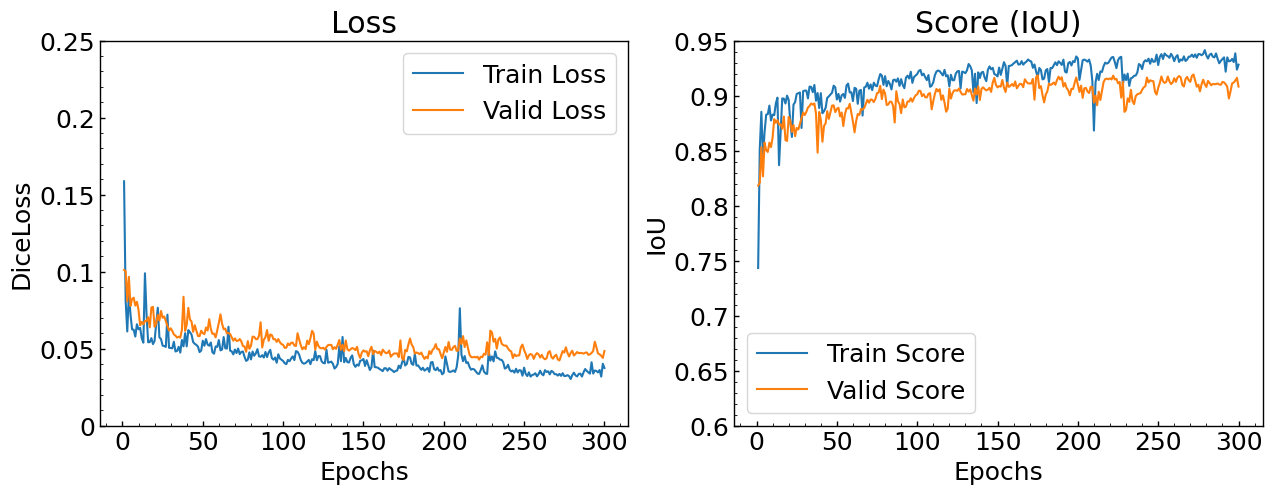

In [10]:
# # 数値の配列を文字列にして返す関数
# def convert_list_el_to_str_from_num(arr_num, num_decimals = 0):
#     arr_str = []
#     for num in arr_num:
#         if num_decimals == 0:
#             stg = str(num)
#         else:
#             stg = str(math.floor(num * 10 ** num_decimals) / (10 ** num_decimals))
#             while True:
#                 if not(stg[-1] in ["0", "."]):
#                     break
#                 elif stg == "0.0":
#                     stg = "0"
#                 else:
#                     stg = stg[:-1]

#         arr_str.append(stg)
#     return arr_str

def convert_list_el_to_str_from_num(arr_num, num_decimals = 0):
    print(arr_num)
    arr_str = []
    for num in arr_num:
        if num_decimals == 0:
            stg = str(num)
        else:
            num_foor = math.floor(num * 10 ** num_decimals) / (10 ** num_decimals)
            print('num_foor:' + str(num_foor))
            stg = str(num_foor)
            print('stg:' + stg)
            while True:
                if not(stg[-1] in ["0", "."]):
                    break
                elif stg == "0.0":
                    stg = "0"
                    break
                else:
                    stg = stg[:-1]
                # pdb.set_trace()
        
        print('append:' + stg)
        arr_str.append(stg)
    return arr_str



plt.figure(1)
plt.figure(figsize=(15,5))
# sns.set_style(style="darkgrid")

if NUM_EPOCHS < 20:
    arange_num = np.arange(1, NUM_EPOCHS+1, step=1)
    arange_str = convert_list_el_to_str_from_num(arange_num)

    # print(arange_str)
    plt.xticks(arange_num, arange_str)
    plt.xlim(1, NUM_EPOCHS)
elif NUM_EPOCHS < 60:
    plt.xticks(np.arange(1, NUM_EPOCHS+1, step=5))
    plt.xlim(0, NUM_EPOCHS)
else:
    plt.xticks(np.arange(1, NUM_EPOCHS+1, step=10))
    plt.xlim(0, NUM_EPOCHS)


plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams["font.size"] = 18
plt.rcParams['axes.linewidth'] = 1.0
# plt.minorticks_on()

# plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
# plt.gca().xaxis.get_major_formatter().set_useOffset(False)
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.locator_params(axis='y',nbins=6)


plt.subplot(1, 2, 1)
arange_num = np.arange(0, 0.25+0.01, step=0.05)
# arange_str = convert_list_el_to_str_from_num(arange_num, 0)
# めんどくさいから自分で指定する
arange_str = ["0", "0.05", "0.1", "0.15", "0.2", "0.25"]
# print(arange_str)
plt.yticks(arange_num, arange_str)
plt.ylim(0, 0.25)
plt.minorticks_on()
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("DiceLoss")


plt.subplot(1, 2, 2)
arange_num = np.arange(0.6, 0.95+0.01, step=0.05)
# arange_str = convert_list_el_to_str_from_num(arange_num, 2)
arange_str = ["0.6", "0.65", "0.7", "0.75", "0.8", "0.85", "0.9", "0.95"]
# print(arange_str)
plt.yticks(arange_num, arange_str)
plt.ylim(0.6, 0.95)
plt.minorticks_on()
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,NUM_EPOCHS+1), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.show()


In [11]:
# bestmodelの読み込み
checkpoint = torch.load(CHECKPOINT_PATH_UNet + best_model_file)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
valid_loss_min = checkpoint['valid_loss_min']

[47, 45, 32, 5, 18, 48]


/tmp/ipykernel_2808/418586582.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = torch.autograd.Variable(data, volatile=True).cuda()
/tmp/ipykernel_2808/418586582.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  mask = torch.autograd.Variable(mask, volatile=True).cuda()


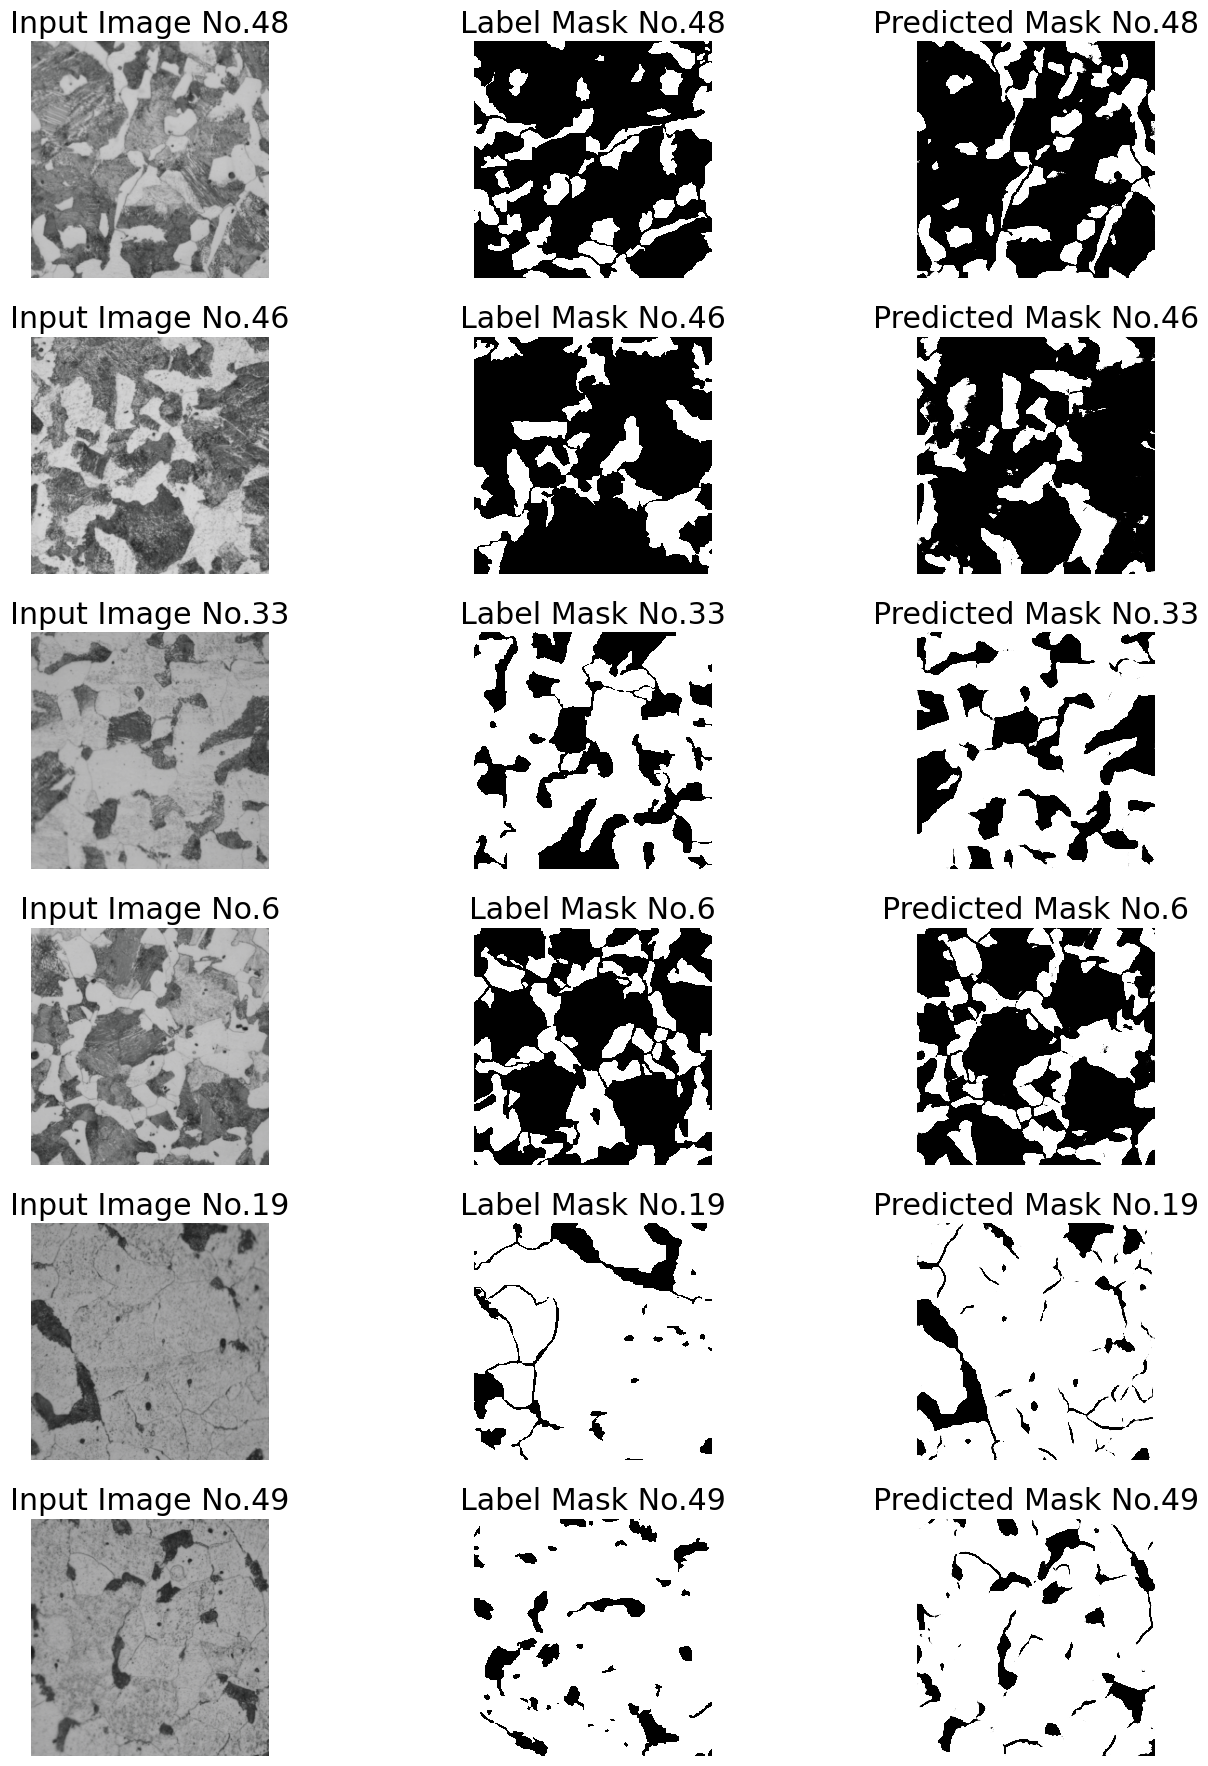

In [12]:
def visualize_predict(model, n_images, num_range):
    images = random.sample(range(0, num_range), n_images)
    print(images)
    # figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
    figure, ax = plt.subplots(nrows=len(images), ncols=3, figsize=(15, 18))
    
    with torch.no_grad():
        for data,mask in val_loader:
            data = torch.autograd.Variable(data, volatile=True).cuda()
            # data = torch.autograd.Variable(data, volatile=True).cpu().numpy()
            mask = torch.autograd.Variable(mask, volatile=True).cuda()
            # mask = torch.autograd.Variable(mask, volatile=True).cpu().numpy()
            o = model(data)
            break
    for i in range(0, len(images)):
        img_no = images[i]
        tm=o[i][0].data.cpu().numpy()
        img = data[i].data.cpu().numpy()
        msk = mask[i].data.cpu().numpy()
        img = format_image(img)
        msk = format_mask(msk)
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(msk, interpolation="nearest", cmap="gray")
        ax[i, 2].imshow(tm, interpolation="nearest", cmap="gray")
        ax[i, 0].set_title(f"Input Image No.{img_no+1}")
        ax[i, 1].set_title(f"Label Mask No.{img_no+1}")
        ax[i, 2].set_title(f"Predicted Mask No.{img_no+1}")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
        # 画像の保存
        plt.imsave(f"../tmp/Input_Image_No_{img_no+1}.png", img)
        plt.imsave(f"../tmp/Label_Mask_No_{img_no+1}.png", msk)
        plt.imsave(f"../tmp/Predicted_Mask_No_{img_no+1}.png", tm)
    plt.tight_layout()
    plt.show()

visualize_predict(model, 6, num_range)